In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Nov 8, 2017

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import loadcoraldata_utils as coralutils
import glob, os

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
import pandas as pd
import logging
from PIL import Image as pil_image

import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from NeMO_models import FCN
import NeMO_layers

%matplotlib notebook

model = load_model('./tmp/fcn_vgg16_model.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D})

Using TensorFlow backend.


In [2]:
transect1_path = '../Images/Transect 1 Hi-Res.tiff'
transect1_truth_path = '../Images/Transect 1 Truth data.tif'

image_size = 150
labels = ('Sand', 'Branching', 'Mounding', 'Rock')
Transect1 = coralutils.CoralData(transect1_path, Truthpath=transect1_truth_path, Testpath = transect1_path, truth_key=[16,160,198,38])
Transect1.load_image(transect1_path, PILflag = True)
Transect1.set_depth(127)

# fcn_vgg16 = FCN(input_shape=(224, 224, 3), classes=21, weight_decay=3e-3, weights='imagenet', trainable_encoder=True)
model = load_model('./tmp/fcn_vgg16_weights.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D})

whole_predict, num_predict, truth_predict, accuracy = Transect1.predict_on_whole_image(model, image_size = 150, num_lines=100, spacing = 25)

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855 completed

2856/ 2855

In [3]:
whole_predict_map = np.copy(whole_predict.astype(np.float32))
whole_predict_map[whole_predict_map == 0] = -1
whole_predict_map = ((whole_predict_map+1)*255/4).astype(np.uint8)
whole_predict_map = cv2.applyColorMap(whole_predict_map, cv2.COLORMAP_JET)
cv2.imwrite('NeMOFCN_visual.png',whole_predict_map)

True

In [4]:
print(accuracy)

50.3174835591


In [67]:
### GONNA TRY SOME TEST CODE
labels = ('Sand', 'Branching', 'Mounding', 'Rock')
labelrandom = random.randint(0,3)
numrandom = random.randint(0,49)
filestr = labels[labelrandom] + '_' + str(numrandom).zfill(8) + '.png'
print('File: ', filestr)

image1_path = '../Images/Valid_Patches/' + filestr
image1_truth_path = '../Images/ValidRef_Patches/' + filestr

image1 = []
tempimage = pil_image.open(image1_path)
image1.append(img_to_array(tempimage))
originalimage = cv2.imread(image1_path)
b,g,r = cv2.split(originalimage)
originalimage = cv2.merge((r,g,b))
truthimage = cv2.imread(image1_truth_path)
truthimagemap_gray = cv2.cvtColor(cv2.imread(image1_truth_path), cv2.COLOR_BGR2GRAY)

#pixel_mean = np.asarray([127,127,127], dtype=np.float)
# pixel_std = np.asarray([127,127, 127], dtype=np.float)
image_size = 150
image1 = np.asarray(image1, dtype=np.float)
image1[0] = image1[0] - 127.0
image1[0] = image1[0]/127.0


predict = model.predict_on_batch(image1)
predict = np.argmax(predict,-1)

labelkey =[0,63,127,191]
if labelkey is not None:
    item_counter = 0
    for item in labelkey:
        truthimagemap_gray[truthimagemap_gray == item ] = item_counter 
        item_counter+=1

accuracy = 100*np.asarray((predict == truthimagemap_gray)).astype(np.float32).sum()/(predict.shape[1]*predict.shape[2])
print(accuracy)

File:  Rock_00000025.png
96.0


[0 3]


<IPython.core.display.Javascript object>


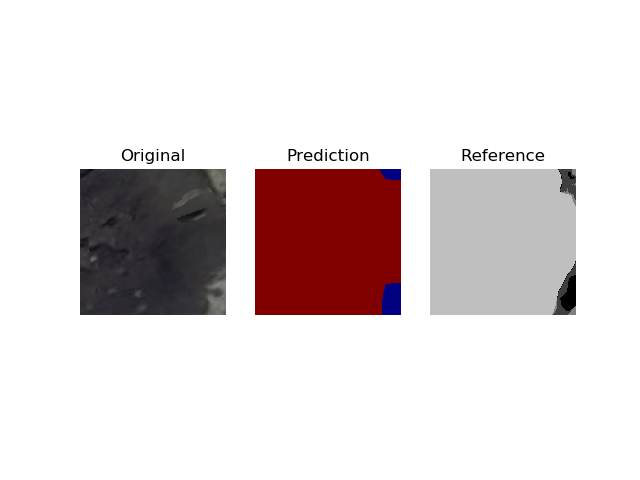

In [68]:
newpredict = predict[0]
print(np.unique(newpredict))

newpredict = np.asarray(newpredict).astype(np.float32)
newpredict[newpredict == 0] = -1
newpredict = ((newpredict+1)*255/4).astype(np.uint8)
newpredict = cv2.applyColorMap(newpredict, cv2.COLORMAP_JET)

b,g,r = cv2.split(newpredict)       # get b,g,r
newpredict = cv2.merge([r,g,b])     # switch it to rgb)
#temp = np.reshape(truth_predict, (truth_predict.shape[0]*truth_predict.shape[1],3))
#colors = np.unique(temp, axis=0)

f, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(originalimage)
ax1.set_title('Original')
ax1.axis('off')
ax2.imshow(newpredict)
ax2.set_title('Prediction')
ax2.axis('off')
ax3.imshow(truthimage)
ax3.set_title('Reference')
ax3.axis('off')
plt.show()